<a href="https://colab.research.google.com/github/rafabenevente/AM_1/blob/main/AM_1_Titanic_Predi%C3%A7%C3%A3o_dos_sobreviventes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [815]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


Titanic: Predição dos Sobreviventes com Machine Learning
===

# Conhecendo o Conjunto de Dados


**Dicionário**

|Variável |Definição|Chave|
|:---- |----|----:|
|survival  | Sobrevivente |0 = Não, 1 = Sim|
|pclass |Classe da ticket| 1 = 1st, 2 = 2nd, 3 = 3rd|
|sex  |Sexo| 	
|Age  | Idade em anos| 	
|sibsp| # de irmãs / cônjuges a bordo do Titanic |
|parch |# de pais / crianças a bordo do Titanic |	
|ticket| ID do ticket| 	
|fare 	|Tarifa de passageiro (libra esterlina)| 	
|cabin 	|número da cabine| 	
|embarked |Porto de embarcação|C = Cherbourg, Q = Queenstown, S = Southampton|


**Observações**
- pclass: Status socieconômico
    - 1st = Alta
    - 2nd = Média
    - 3rd = Baixa
- age: A idade é fracionária se menor que 1. Se a idade for estimada, é na forma de xx.5

- sibsp: O conjunto de dados define as relações familiares desta forma ...
    - Sibling = irmão, irmã, meio-irmão, meia-irmã
    - Spouse = marido, esposa (amantes e noivos foram ignorados)

- parch: O conjunto de dados define as relações familiares desta forma ...
    - Parent = mãe, pai
    - Child = filha, filho, enteada, enteado
    - Algumas crianças viajavam apenas com a babá, portanto parch = 0 para elas.



## Importação e características

In [816]:
test_url = 'https://raw.githubusercontent.com/rafabenevente/AM_1/main/test.csv'
train_url = 'https://raw.githubusercontent.com/rafabenevente/AM_1/main/train.csv'
validation_url = 'https://raw.githubusercontent.com/galvaowesley/MachineLearning_Learning/master/Titanic%20-%20Suvivors%20Classification/gender_submission.csv'

# Importa as bibliotecas de cálculo e manipulação de dados
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from  matplotlib.ticker import PercentFormatter
import seaborn as sns


In [817]:
# Fonte: https://stackoverflow.com/questions/63745343/annotate-percentage-of-group-within-a-seaborn-countplot
def barPlotPercent(df, atributo1, atributo2):
  '''
  Função que recebe um dataframe e dois atributos categóricos, realiza o agrupamento 
  de ambos e mostra a contagem e percentual do atributo1 em função do atributo2. 
  '''

  # prepare the dataset
  df = (df
        .groupby([atributo1, atributo2])
        .size()
        .reset_index()
        #.replace({"Survived": {0:"no", 1:"yes"}})
        .rename(columns={0:"count"}))

  # Calcula o percentual do atributo2 % por níveis do atributo1.
  df["percent"] = (df
                  .groupby(atributo1)
                  .apply(lambda x: x["count"] / x["count"].sum()).values)

  # sort the dataframe to match the drawing order
  df.sort_values(by=[atributo2, atributo1], inplace=True)

  # Visualização
  plt.style.use('ggplot')
  fig = sns.catplot(
    x="count", y=atributo1, hue=atributo2,
    kind="bar", data=df, height=4, aspect=2)

  for i, bar in enumerate(fig.ax.patches):
    
      height = bar.get_height()
      fig.ax.annotate(
          # reference the pre-calculated row in the dataframe
          f"{df.iloc[i, 3] :.0%}",
          xycoords="data",
          xytext=(20, -15),
          textcoords="offset points",
          xy=(bar.get_width(), bar.get_y()),
          ha='center', va='center')

  # make space for annonations
  plt.margins(x=0.2)
  plt.show()

In [818]:
# Carregamento daa base de dados inicialmente separada em treino e teste
train = pd.read_csv(train_url)
test =  pd.read_csv(test_url)

In [819]:
# Dimensão da base de dados
print("Treino tem {} linhas e {} colunas \n". format(train.shape[0], train.shape[1]))
print("Teste tem {} linhas e {} colunas \n". format(test.shape[0], test.shape[1]))

Treino tem 891 linhas e 12 colunas 

Teste tem 418 linhas e 11 colunas 



Há, portanto, 1309 linhas ao total. O conjunto de dados original sofreu split na proporção: 68% para treino e 32% para teste. 

In [820]:
# Aparência do train
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [821]:
# Tipo de dados das variáveis
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Engenharia de atributos



## Junção dos datasets de treino e teste

Tanto os dados dados para treino quanto para teste foram concatenados para que todo o conjunto passasse por transformações durante a engenharia de atributos. 

In [822]:
print(f"Train shape {train.shape}")
print(f"Test shape {test.shape}")

# salvar os índices dos datasets para recuperação posterior
train_idx = train.shape[0]
test_idx = test.shape[0]

# concatenar treino e teste em um único DataFrame
all_data = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

print(f"All_data shape {all_data.shape}")

Train shape (891, 12)
Test shape (418, 11)
All_data shape (1309, 12)


Antes das transformações, vale a pena verificar o nível de correlação entre os atributos para que se possa gerar insights e outros atributos a partir dos pares que possuam maiores correlações. 

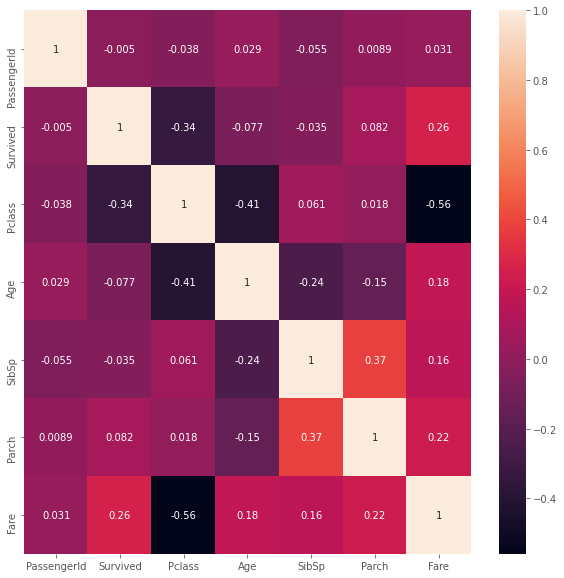

In [823]:
# Heatmap de coeficiente de correlação entre as variáveis
plt.figure(figsize=(10,10))
sns.heatmap(all_data.corr(), annot = True)

## Imputação de dados ausentes

O conjunto de dados do Titanic apresenta dados faltantes em alguns atributos, como `Age`, `Cabin`, `Fare` e `Embarked`. Nesta seção, algumas estratégias de imputação de dados foram utilizadas para poder preencher os campos vazios.

In [824]:
# Contagem de dados faltantes por atributo
all_data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

### Age

A abordagem de imputação de dados para `Age`  é baseada no preenchimento dos campos faltantes com medidas de tendência central. Para tanto, verificou-se a o formato da distribuição a fim de se escolher a melhor medida. 

In [825]:
# Sumário estatístico do atributo Age
round(all_data['Age'].describe(), 2)

count    1046.00
mean       29.88
std        14.41
min         0.17
25%        21.00
50%        28.00
75%        39.00
max        80.00
Name: Age, dtype: float64

Como se vê, a média da idade é 29,88 anos, enquanto a mediana é 28,00. Esta proximidade releva que a distribuição de idade tende à normal. Para tanto, o histograma pode ajudar na visualização dessa distribuição. 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


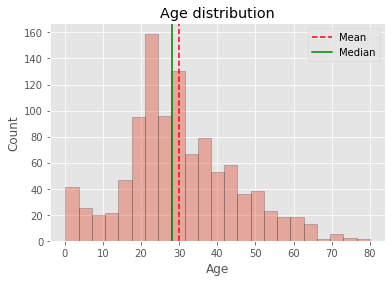

In [826]:
# Cálculo da média e mediana
mean = all_data['Age'].mean()
median =all_data['Age'].median()

plt.title("Age distribution")
sns.distplot(a=all_data['Age'], kde = False,
             hist_kws = {'edgecolor':'black'})
plt.axvline(mean, color='r', linestyle='--')
plt.axvline(median, color='g', linestyle='-')

plt.ylabel("Count")
plt.legend({'Mean':mean,'Median':median})
plt.show()


A distribuição aparenta estar positivamente enviesada para direita, portanto, a mediana pode ser utilizada como uma substituta para dados faltantes.

Contudo, preencher todos 263 campos vazios com um único valor de mediana pode não ser uma boa ideia, pois as idades estão distribuídas em diferentes grupos de passageiros. Como realizado por Gunes Evitan em seu trabalho "*Titanic - Advanced Feature Engineering Tutorial*" [1], os atributos `Age` e `Pclass` possuem uma média correlação de -0,41. Em adição, todas as classes sociais são compostas por ambos os sexos. Logo, a imputação para `Age` pode ser realizada com a mediana, dada a classe social e sexo do indivíduo. Assim: 

In [827]:
# Mediana da idade agrupada por PClass e Sex 
age_pclass = all_data.groupby(['Sex','Pclass']).describe()['Age']
round(age_pclass,2)

count   mean    std   min   25%   50%    75%   max
Sex    Pclass                                                    
female 1       133.0  37.04  14.27  2.00  24.0  36.0  48.00  76.0
       2       103.0  27.50  12.91  0.92  20.0  28.0  34.00  60.0
       3       152.0  22.19  12.21  0.17  16.0  22.0  30.00  63.0
male   1       151.0  41.03  14.58  0.92  30.0  42.0  50.00  80.0
       2       158.0  30.82  13.98  0.67  23.0  29.5  38.75  70.0
       3       349.0  25.96  11.68  0.33  20.0  25.0  32.00  74.0

In [828]:
# Preenche os NA's com a mediana da idade por classe social
all_data['Age'] = all_data.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

### Fare

Semelhantemente, o atributo de custo do ticket `Fare` precisa de imputação para 1 campo vazio. Para tanto, é necessário escolher a melhor medida de centralidade, então verifica-se a distribuição dos valores ao longo do conjunto de dados. 

In [829]:
# Contagem de 
fare_pclass = all_data.groupby(['Pclass']).describe()['Fare']
fare_pclass

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,323.0,87.508992,80.447178,0.0,30.6958,60.0000,107.6625,512.3292
2,277.0,21.179196,13.607122,0.0,13.0000,15.0458,26.0000,73.5000
3,708.0,13.302889,11.494358,0.0,7.7500,8.0500,15.2458,69.5500


Como se vê, a quantidade de tickets na classe 3 é bem maior que as duas primeiras classes, tornando a distribuição enviesada positivamente. 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


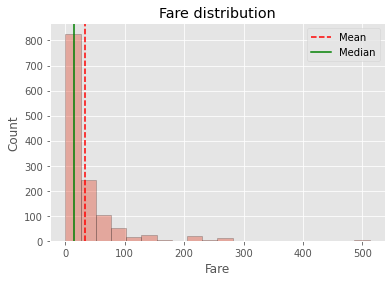

In [830]:
# Cálculo da média e mediana
mean = all_data['Fare'].mean()
median =all_data['Fare'].median()

plt.title("Fare distribution")
sns.distplot(a=all_data['Fare'], bins = 20, 
             kde = False, 
             hist_kws = {'edgecolor':'black'})
plt.axvline(mean, color='r', linestyle='--')
plt.axvline(median, color='g', linestyle='-')

plt.ylabel("Count")
plt.legend({'Mean':mean,'Median':median})
plt.show()


Para a imputação de dados, utilizou-se a mediana como substituto para o único dadod faltante. 

In [831]:
# Fill NA's with Fare median
fare_median = all_data['Fare'].median()
all_data['Fare'].fillna(fare_median, inplace=True)

### Cabin

O atributo `Cabin` é um caso especial que possui 1014 dados faltantes. O posicionamento da cabine pode ter contribuído com a taxa de sobrevivência de dos passageiros, de acordo com a classe social, uma vez que os decks mais  ao topo estavam próximos dos botes salva-vidas. Logo, esse atributo pode ter alguma contribuição na criação do modelo de predição. Novamente, a estratégia utilizada nesse atributo foi baseada no trabalho de Gunes Evitan [1].

Os dados da variável `Cabin` estão formatados assim: 
 * Primeiro carácter: Identificação do deck
 * Caracteres seguintes: número da cabine. 


 ![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/800px-Titanic_cutaway_diagram.png)

Fonte: https://en.wikipedia.org/wiki/First-class_facilities_of_the_Titanic#/media/File:Titanic_cutaway_diagram.png

In [832]:
# Lista os nomes únicos das cabines
all_data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Optou-se em criar um novo atributo chamado `Deck` que contém o primeiro carácter da respectiva cabine. Para os campos faltantes, o preenchimento foi feito com o carácter `U`  de Unknown. 

In [833]:
# Preenche os NA's com a letra U de Unknown
all_data['Deck'] = all_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'U')

Agora, observa-se a distribuição de custo de ticket agrupados por classe social e deck. Nota-se que a classe social mais é composto por pessoas que ocuparam os decks de **A** à **E**, e uma única pessoa no deck **T**. Indivíduos da classes sociail média estão presentes nos decks **D**, **E** e **F**, enquanto as da classe baixa estão presentes nos decks **E**, **F** e **G**. 

Nota-se também que há um grande número de indentificação desconhecida de deck e cabine para as classes média e baixa. 

In [834]:
# Sumário do custo do ticket agrupado por Pclass e Deck. 
deck_pclass = all_data.groupby(['Pclass', 'Deck']).describe()['Fare']
deck_pclass

count        mean         std  ...       50%         75%       max
Pclass Deck                                 ...                                
1      A      22.0   41.244314   20.140358  ...  35.07710   50.371850   81.8583
       B      65.0  122.383078  115.312993  ...  82.26670  146.520800  512.3292
       C      94.0  107.926598   72.912034  ...  86.28960  151.550000  263.0000
       D      40.0   58.919065   25.256615  ...  53.10000   76.868775  113.2750
       E      34.0   63.464706   35.322753  ...  55.44170   79.650000  134.5000
       T       1.0   35.500000         NaN  ...  35.50000   35.500000   35.5000
       U      67.0   70.268157   80.114953  ...  39.60000   79.200000  512.3292
2      D       6.0   13.595833    0.829640  ...  13.39585   13.844800   15.0458
       E       4.0   11.587500    1.283469  ...  11.42500   12.512500   13.0000
       F      13.0   23.423077   12.306580  ...  26.00000   39.000000   39.0000
       U     254.0   21.394537   13.843615  ...  15.66460   26.000000   73.5000
3      E       3.0   11.000000    2.554775  ...  12.47500   12.475000   12.4750
       F       8.0    9.395838    5.241519  ...   7.65000    7.675000   22.3583
       G       5.0   14.205000    3.416419  ...  16.70000   16.700000   16.7000
       U     693.0   13.353114   11.593703  ...   8.05000   15.245800   69.5500

[15 rows x 8 columns]

Sendo assim, escolheu-se agrupar os decks. **A**, **B** e **C** formam o grupo **ABC**. **D** e **E** formam o **DE**. **F** e **G** formam **FG**. 
A pessoa que estava no deck **T** foi transferida para o deck **A**, por ser da classe social mais alta. 

In [835]:
# Agrupamento dos decks
idx = all_data[all_data['Deck'] == 'T'].index
all_data.loc[idx, 'Deck'] = 'A'

all_data['Deck'] = all_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
all_data['Deck'] = all_data['Deck'].replace(['D', 'E'], 'DE')
all_data['Deck'] = all_data['Deck'].replace(['F', 'G'], 'FG')
all_data['Deck'].value_counts()

U      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

### Embarked

Para o atributo `Embarked`, verificou-se as linhas que estavam com os dados faltantes. Uma vez que há apenas duas ocorrências, dada a classe social `Pclass == 1` para ambos, os dados foram imputados com a identificação do porto onde há maior ocorrência dessa classe social, ou seja, do porto Cherbourg(C). 

In [836]:
all_data.query('Embarked != "S" & Embarked != "C" & Embarked != "Q"')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,ABC
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,ABC


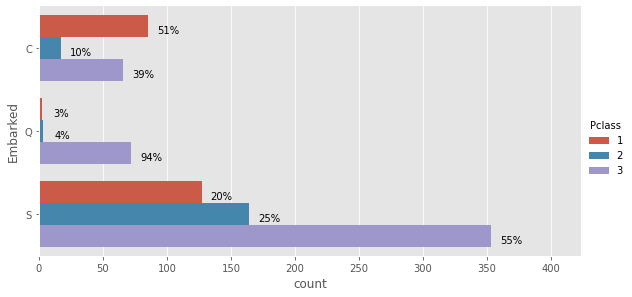

In [837]:
# Visualização de Classe Social por Porto de Embarcação
barPlotPercent(train, 'Embarked', 'Pclass')

In [838]:
# embarked
embarked_top = all_data['Embarked'].value_counts()[0]
all_data['Embarked'].fillna('C', inplace=True)

## Novos atributos

### AgeGroup

Um novo atributo categórico foi criado a partir do atributo `Age`. Separou-se as idades em intervalos a fim de os identificar em grupos etários. São eles:


*   Child: menor que 12 anos
*   Teenager: de 12 à 20 anos
*   Adult: de 21 à 49 anos
*   Old: maior ou igual à 50 anos


Durante a pesquisa, não se encontrou alguma fonte sobre a classifição etária no começo do século XX na Europa, mas neste fórum de discussão há uma menção da maioridade penal a partir dos 21 anos. [Age of Majority - Enciclopedia Titanica](https://www.encyclopedia-titanica.org/community/threads/age-of-majority.4620/
).

In [839]:
# Cria o atributo AgeGroup que categoriza o passageiro de acordo com a sua idade
all_data['AgeGroup']  = ''
for row in all_data.index:
  if all_data['Age'][row] < 12.0:
    all_data['AgeGroup'][row]  = 'Child'
  if all_data['Age'][row] >= 12.0 and all_data['Age'][row] < 21.0:
    all_data['AgeGroup'][row]  = 'Teenager'
  if all_data['Age'][row] >= 21.0 and all_data['Age'][row] < 50.0:
    all_data['AgeGroup'][row]  = 'Adult'
  if all_data['Age'][row] >= 50.0:
    all_data['AgeGroup'][row]  = 'Old'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python

### Title

Outro atributo interessante para ser avaliado e até mesmo utilizado como estimador no modelo de classificação, é o título que o passageiro recebe. Os títulos podem variar de acordo com a classe social, idade e sexo [2].

Sendo assim, extrai-se os títulos de cada nome a fim de listá-los.





In [840]:
# Extrai os títulos dos nomes e armazena num atributo próprio
all_data['Title'] = all_data['Name'].str.extract(' ([A-Za-z]+)\.')
# Lista os atributos por Sexo
pd.crosstab(all_data['Title'], all_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


Uma vez listados, os títulos que tiveram menor ocorrência foram agrupados àqueles mais comuns, que condizem com o sexo e estado civil. São eles : **Mr**, **Mrs**, **Miss** e **Master**.
 Esta estratégia foi baseada no artigo tutorial "*Basic Feature Engineering with the Titanic Data*" [3].


In [841]:
# Substituição dos sortidos títulos por Mr, Mrs, Miss e Master
def replace_titles(x):
    title=x['Title']
    if title in ['Sir', 'Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
all_data['Title']=all_data.apply(replace_titles, axis=1)

In [842]:
# Lista os 
all_data.groupby(['Title'])['Title'].count()

Title
Master     61
Miss      264
Mr        775
Mrs       209
Name: Title, dtype: int64

### FamilySize

O tamanho da família é definido pela soma dos atributos `SibSp` e`Parch` mais 1. Este último corresponde ao indivíduo, que pode estar viajando sozinho. 

In [843]:
# Cria o atributo que corresponde ao tamanho da família à bordo
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1

Posteriormente, mapeou-se o tamanho da família em categorias, de acordo como número de pessoas. 

In [844]:
all_data['FamilySize'] = all_data['FamilySize'].map({1: 'Alone', 2: 'Small', 
                                                    3: 'Small', 4: 'Small', 
                                                    5: 'Medium', 6: 'Medium', 
                                                    7: 'Large', 8: 'Large', 
                                                    11: 'Large'})

# Análise Exploratória dos Dados

Nesta seção, explorou-se estatística e visualmente os atributos e suas relações entre si. 

## Survived

No atributo classe e considerando o dataset de treino, há o total de 342 sobrevimentes contra 549 não sobreviventes.

In [845]:
all_data[:train_idx].groupby(['Survived'])['Survived'].count()

Survived
0.0    549
1.0    342
Name: Survived, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Survived')

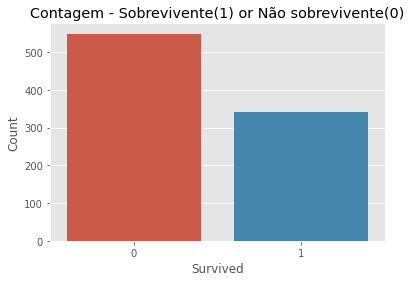

In [846]:
# Contagem de sobreviventes e não sobreviventes
plt.title("Contagem - Sobrevivente(1) or Não sobrevivente(0)")
sns.countplot(train.Survived)
plt.ylabel("Count")
plt.xlabel("Survived")

## Sex

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Sex')

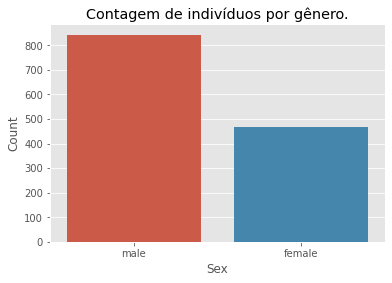

In [847]:
# Contagem de indivíduos por gênero.
plt.title("Contagem de indivíduos por gênero.")
sns.countplot(all_data.Sex)
plt.ylabel("Count")
plt.xlabel("Sex")

Considerando a amostra treino, apenas 19% dos homens sobreviveram, contra 74% das mulheres. 

In [848]:
# Sumarização de Survived por gênero
all_data[:train_idx].groupby(['Survived', 'Sex'])['Sex'].count()

Survived  Sex   
0.0       female     81
          male      468
1.0       female    233
          male      109
Name: Sex, dtype: int64

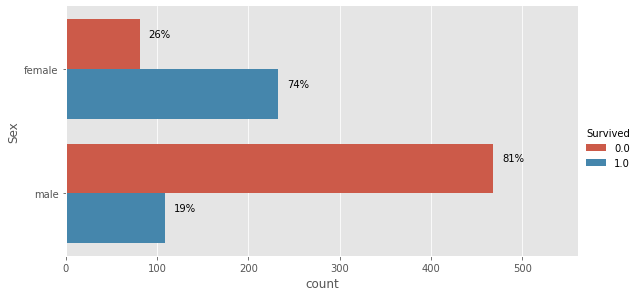

In [849]:
# Visualização de Survived por gênero
barPlotPercent(all_data[:train_idx], 'Sex', 'Survived')

Sendo assim, criou-se um novo atributo correspondente à taxa de sobr

In [850]:
all_data['Sex_survival_rate'] = all_data.Sex.map(lambda x: 0.74 if x == 'female' else 0.26)

## Pclass

Ao observar o atributo Pclass, nota-se que a classe social que prevalece é a baixa. Contudo, foi a classe com maior taxa de morte. 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Pclass')

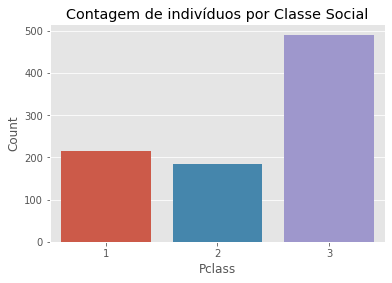

In [851]:
# Contagem de passageiros por Classe Social
plt.title("Contagem de indivíduos por Classe Social")
sns.countplot(train.Pclass)
plt.ylabel("Count")
plt.xlabel("Pclass")

In [852]:
# Sumarização de Survived por classe social
all_data[:train_idx].groupby(['Survived', 'Pclass'])['Pclass'].count()

Survived  Pclass
0.0       1          80
          2          97
          3         372
1.0       1         136
          2          87
          3         119
Name: Pclass, dtype: int64

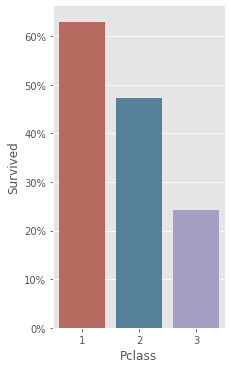

In [853]:
# Taxa de sobrevivência por classe social
g = sns.catplot(x="Pclass", y="Survived",
                 data=train, saturation=.5,
                 kind="bar", ci=None, aspect=.6)

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

Sendo assim, criou-se um novo atributo da taxa de sobrevivência, dada a classe social. 

In [854]:
# Calcula a taxa de sobrevivência entre as classes sociais Pclass
p1_surv_rate = round((136/(136+80)),2)
p2_surv_rate = round((87/(87+97)),2)
p3_surv_rate = round((119/(119+372)),2)

print(' Pclass1 survival rate: {} \n Pclass2 survival rate: {} \n \
Pclass3 survival rate: {}'.format(p1_surv_rate, p2_surv_rate, p3_surv_rate))

 Pclass1 survival rate: 0.63 
 Pclass2 survival rate: 0.47 
 Pclass3 survival rate: 0.24


In [855]:
# Mapeia a taxa de sobrevivência para cada passageiro de acordo com a sua classe social
all_data['Plass_survival_rate'] = all_data.Pclass.map({1 : p1_surv_rate, 2: p2_surv_rate, 3:p3_surv_rate})

Na availiação cruzada entre `Pclass` e `Sex` nota-se que o número de homens na classe social mais baixa é muito maior em comparação às outras classes sociais. 

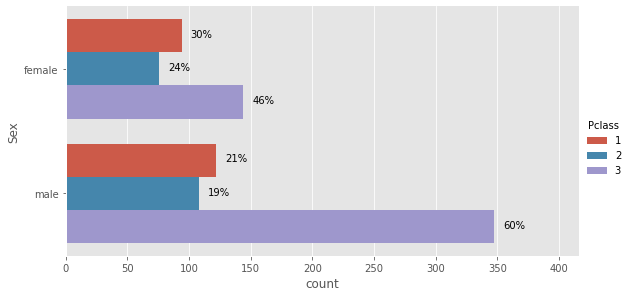

In [856]:
# Percentual e contagem de indivíduos por Classe Social e sexo
barPlotPercent(all_data[:train_idx], 'Sex', 'Pclass')

Os dados também revelam que independente da classe social, as mulheres foram as que tiveram a maior taxa de sobrevivência. 

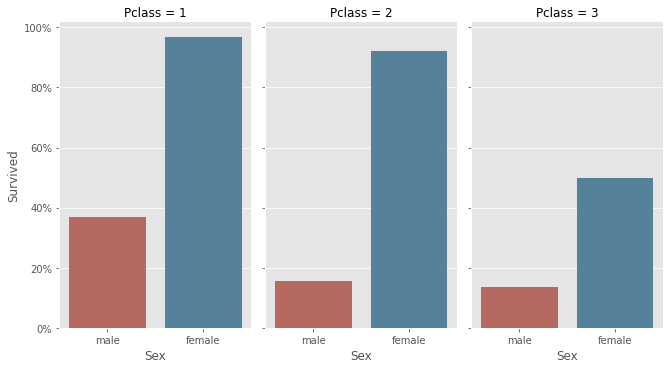

In [857]:
# Percentual de sobreviventes por sexo e classe social
g = sns.catplot(x="Sex", y="Survived", col="Pclass",
                 data=all_data[:train_idx], saturation=.5,
                 kind="bar", ci=None, aspect=.6)

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

## Age e AgeGroup

Considerando o grupo etário, a maioria dos passageiros é composta por pessoas adultas do sexo masculino. Há também um número considerável de adolescentes.  

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'AgeGroup')

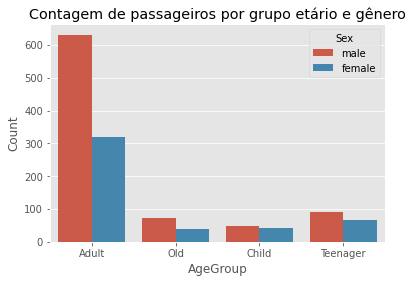

In [858]:
# Contagem de passageiros por grupo etário e gênero
plt.title("Contagem de passageiros por grupo etário e gênero")
sns.countplot(all_data.AgeGroup, hue=all_data.Sex)
plt.ylabel("Count")
plt.xlabel("AgeGroup")

Ao avaliar `AgeGroup` com `Survived`, verifica-se que a maior taxa de mortos foi entre os idosos, contra a maior taxa de sobrevivência entre as crianças. 

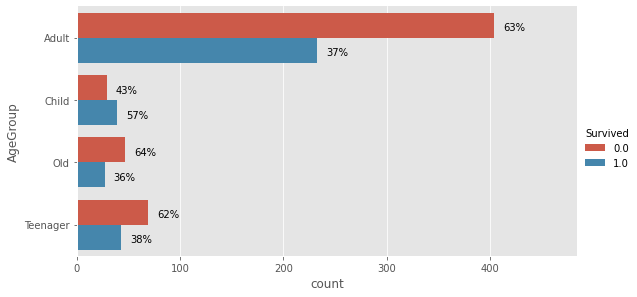

In [859]:
barPlotPercent(all_data, 'AgeGroup', 'Survived')

Olhando mais de perto, pouquíssimos idosos homens se salvaram. Apenas 7 dos 52 idosos homens. 

In [860]:
all_data[:train_idx].groupby(['AgeGroup', 'Sex','Survived'])['Sex'].describe()

count unique     top freq
AgeGroup Sex    Survived                          
Adult    female 0.0         55      1  female   55
                1.0        160      1  female  160
         male   0.0        349      1    male  349
                1.0         73      1    male   73
Child    female 0.0         13      1  female   13
                1.0         19      1  female   19
         male   0.0         16      1    male   16
                1.0         20      1    male   20
Old      female 0.0          2      1  female    2
                1.0         20      1  female   20
         male   0.0         45      1    male   45
                1.0          7      1    male    7
Teenager female 0.0         11      1  female   11
                1.0         34      1  female   34
         male   0.0         58      1    male   58
                1.0          9      1    male    9

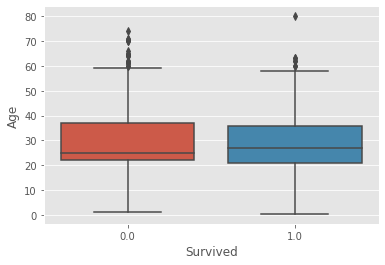

In [861]:
#Boxplot Survived x Age
sns.boxplot(x='Survived', y='Age', data=all_data[:train_idx])
plt.show()

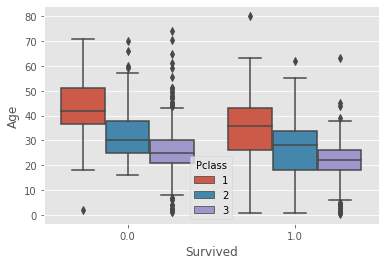

In [862]:
#Boxplot Survived x Age agrupados pela Pclass
sns.boxplot(x='Survived', y='Age', data=all_data[:train_idx], hue='Pclass')

## Family Size

O atributo `FamilySize` releva algumas coisas interessantes, como que grande parte que quem viajou sozinho é do sexo masculino, e a maior taxa de mortes está justamente entre quem viajou só. Claro, o número de homens tem grande influência nessa taxa. 

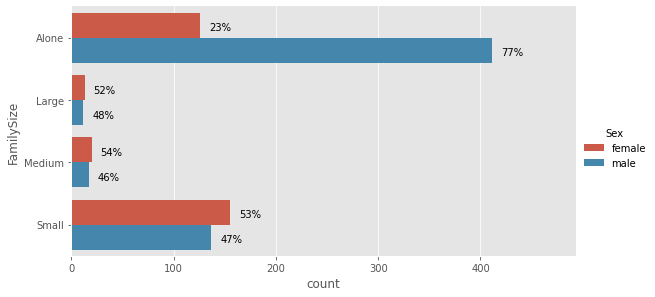

In [863]:
barPlotPercent(all_data[:train_idx], 'FamilySize', 'Sex')

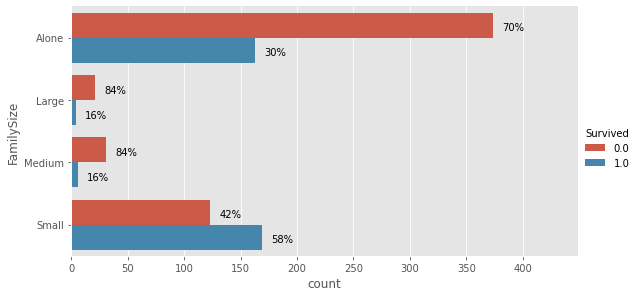

In [864]:
barPlotPercent(all_data[:train_idx], 'FamilySize', 'Survived')

Mesmo entre os da classe mais alta, há um número expressivo de pessoas que viajaram sozinhas. Outra coisa curiosa é que o grupo familiar considerado grande só é encontrado na classe social mais baixa. 

In [865]:
all_data.groupby(['Pclass','FamilySize'])['FamilySize'].describe()

count unique     top freq
Pclass FamilySize                          
1      Alone        160      1   Alone  160
       Medium        11      1  Medium   11
       Small        152      1   Small  152
2      Alone        158      1   Alone  158
       Medium         2      1  Medium    2
       Small        117      1   Small  117
3      Alone        472      1   Alone  472
       Large         35      1   Large   35
       Medium        34      1  Medium   34
       Small        168      1   Small  168

## Deck

No gráfico seguinte, avalia-se a taxa de sobrevivência dada a classe social e grupo de Deck. 

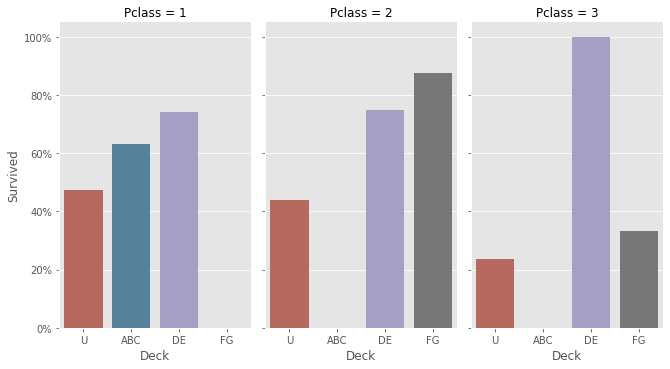

In [866]:
g = sns.catplot(x="Deck", y="Survived", col="Pclass",
                 data=all_data[:train_idx], saturation=.5,
                 kind="bar", ci=None, aspect=.6)

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

Curiosamente, todas as pessoas que estavam faziam parte do grupo de deck **DE** e eram da classe social mais baixa sobreviveram. São elas: 

In [867]:
# Query dos passageiros que estavam nos decks DE e são da classe social mais baixa.
all_data[:train_idx].query('Deck == "DE" & Pclass == 3')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,AgeGroup,Title,FamilySize,Sex_survival_rate,Plass_survival_rate
429,430,1.0,3,"Pickard, Mr. Berk (Berk Trembisky)",male,32.0,0,0,SOTON/O.Q. 392078,8.050,E10,S,DE,Adult,Mr,Alone,0.26,0.24
751,752,1.0,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.475,E121,S,DE,Child,Master,Small,0.26,0.24
823,824,1.0,3,"Moor, Mrs. (Beila)",female,27.0,0,1,392096,12.475,E121,S,DE,Adult,Mrs,Small,0.74,0.24


## Title

Sobre os títulos, a maioria das pessoas, no caso homens,  são intituladas como **Mr**. Consequentente, apresenta a maior taxa de mortos. 

In [868]:
all_data.groupby(['Sex', 'Title'])['Title'].describe()

count unique     top freq
Sex    Title                           
female Miss     264      1    Miss  264
       Mrs      202      1     Mrs  202
male   Master    61      1  Master   61
       Mr       775      1      Mr  775
       Mrs        7      1     Mrs    7

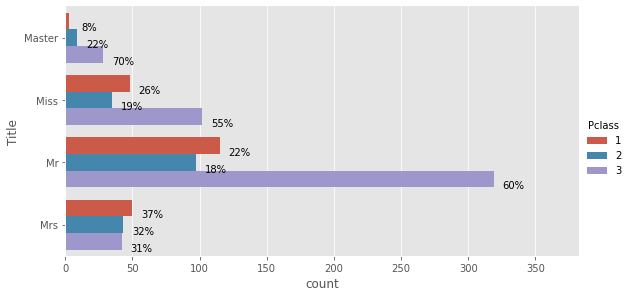

In [869]:
# Percentual e contagem de indivíduos por Título e classe social
barPlotPercent(all_data[:train_idx], 'Title', 'Pclass')

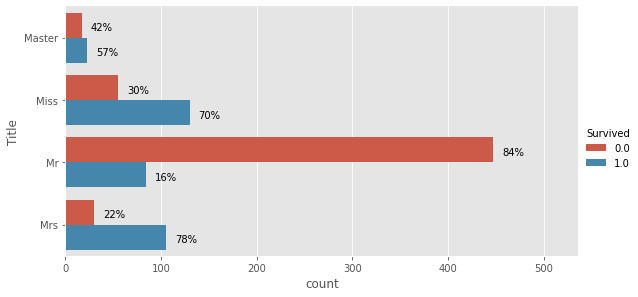

In [870]:
# Percentual e contagem de indivíduos por Título e classe e sobreviventes
barPlotPercent(all_data[:train_idx], 'Title', 'Survived')

# Modelos de predição

## Pré-processamento

### Normalização 

Foi realizada a normalização sobre os atributos `Fare` e `Age`.


In [871]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

all_data[['Fare','Age']] = minmax.fit_transform(all_data[['Fare','Age']] )

### Remoção de colunas e preparação de variáveis

In [872]:
# Remoção de colunas que não serão usadas
all_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Parch', 'SibSp'], axis=1, inplace=True)

# Preparação de variaveis
all_data['Sex'] = all_data['Sex'].map({'male': 0, 'female': 1}).astype(int)
all_data['Embarked'] = all_data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
all_data['AgeGroup'] = all_data['AgeGroup'].map( {'Child': 0, 'Teenager': 1, 'Adult': 2, 'Old':3} ).astype(int)
all_data['Title'] = all_data['Title'].map( {'Mr':0, 'Mrs':1, 'Miss':2, 'Master':3} ).astype(int)
all_data['Deck'] = all_data['Deck'].map( {'ABC':0, 'DE':1, 'FG':2, 'U': 3} ).astype(int)
all_data['FamilySize'] = all_data['FamilySize'].map( {'Alone':0, 'Small':1, 'Medium':2, 'Large': 3} ).astype(int)


In [873]:
all_data.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,Deck,AgeGroup,Title,FamilySize,Sex_survival_rate,Plass_survival_rate
0,0.0,3,0,0.273456,0.014151,0,3,2,0,1,0.26,0.24
1,1.0,1,1,0.473882,0.139136,1,0,2,1,1,0.74,0.63
2,1.0,3,1,0.323563,0.015469,0,3,2,2,0,0.74,0.24
3,1.0,1,1,0.436302,0.103644,0,0,2,1,1,0.74,0.63
4,0.0,3,0,0.436302,0.015713,0,3,2,0,0,0.26,0.24


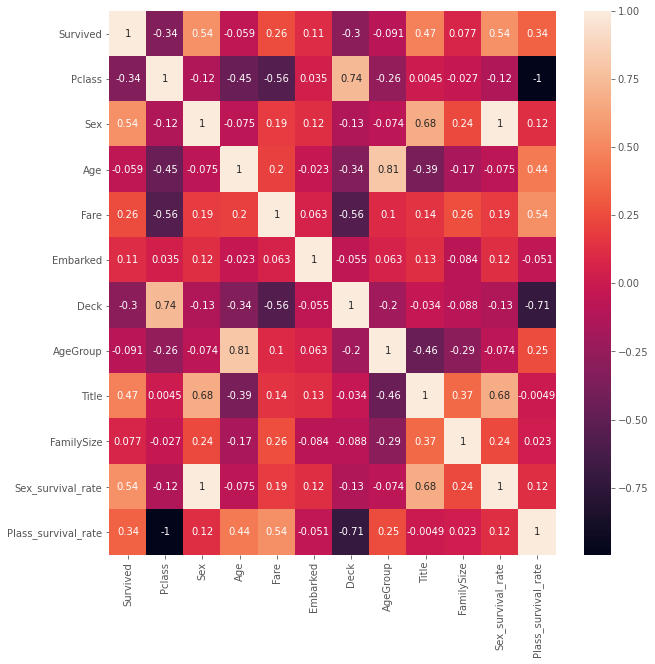

In [874]:
# Heatmap de coeficiente de correlação entre as variáveis
plt.figure(figsize=(10,10))
sns.heatmap(all_data.corr(), annot = True)

### Criação de variáveis Dummies

Os atributos categóricos com mais de uma categoria foram transformados em variáveis *Dummies*, para que cada uma das suas categorias se transformace num novo atributo binário. 

In [875]:
# Criação de dummies para atributos categóricos

embarked_dummies = pd.get_dummies(all_data['Embarked'], prefix='Embarked')
all_data = pd.concat([all_data, embarked_dummies], axis=1)
all_data.drop('Embarked', axis=1, inplace=True)

AgeGroup_dummies = pd.get_dummies(all_data['AgeGroup'], prefix='AgeGroup')
all_data = pd.concat([all_data, AgeGroup_dummies], axis=1)
all_data.drop('AgeGroup', axis=1, inplace=True)

Title_dummies = pd.get_dummies(all_data['Title'], prefix='Title')
all_data = pd.concat([all_data,Title_dummies], axis=1)
all_data.drop('Title', axis=1, inplace=True)

Deck_dummies = pd.get_dummies(all_data['Deck'], prefix='Deck')
all_data = pd.concat([all_data,Deck_dummies], axis=1)
all_data.drop('Deck', axis=1, inplace=True)

FamilySize_dummies = pd.get_dummies(all_data['FamilySize'], prefix='FamilySize')
all_data = pd.concat([all_data,FamilySize_dummies], axis=1)
all_data.drop('FamilySize', axis=1, inplace=True)



### Separação dos datasets



In [876]:
# salvar PassengerId para submissao ao Kaggle
passengerId = test['PassengerId']

# carregamento do dataset de validação disponibilizado pelo Kaggle
validation  = pd.read_csv(validation_url)

# Extração do atributo classe Survived
Y_train = train.Survived.copy() 
# Cópia do df tratado até o índice correpondente ao treino
X_train = all_data.iloc[:train_idx]
# Remoção do atributo Survived
X_train.drop(['Survived'], axis=1, inplace=True) 

# Cópia do df tratado até o índice correpondente ao teste
X_test = all_data.iloc[train_idx:]
# Remoção do atributo Survived
X_test.drop(['Survived'], axis=1, inplace=True) 

print(X_train.shape), print(X_test.shape)

(891, 25)
(418, 25)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(None, None)

## Split

O dataset de treino foi separado em 70% de treino e 30% de teste para que os modelos pudessem ser treinados. 

In [877]:
from sklearn.model_selection import train_test_split
# Separação treino e teste
tr_x, te_x, tr_y, te_y = train_test_split(X_train, Y_train,
                                            test_size = 0.3,
                                            random_state=42,
                                            stratify = Y_train)

## Random Forest

In [878]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, r2_score, roc_curve, auc, classification_report

param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': range(2,6,2),
              'min_samples_leaf': range(2,6,2), 
              'n_estimators': range(2,1000,100)}

rdf = RandomForestClassifier()
gs = GridSearchCV(rdf, param_grid=param_grid)
gs.fit(tr_x, tr_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

### Predição e avaliação do modelo

In [879]:
from sklearn.metrics import accuracy_score, r2_score, roc_curve, auc, classification_report
# Melhores parametros apontados pelo grid search
rdf = gs.best_estimator_

rdf.fit(tr_x, tr_y)
y_pred = rdf.predict(te_x)
print(classification_report(te_y, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       165
           1       0.76      0.72      0.74       103

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.81      0.80       268



[[142  23]
 [ 29  74]]


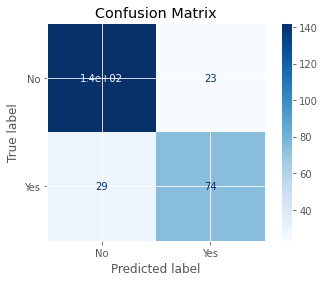

In [880]:
disp = plot_confusion_matrix(rdf, te_x, te_y,
                                 display_labels=["No", "Yes"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

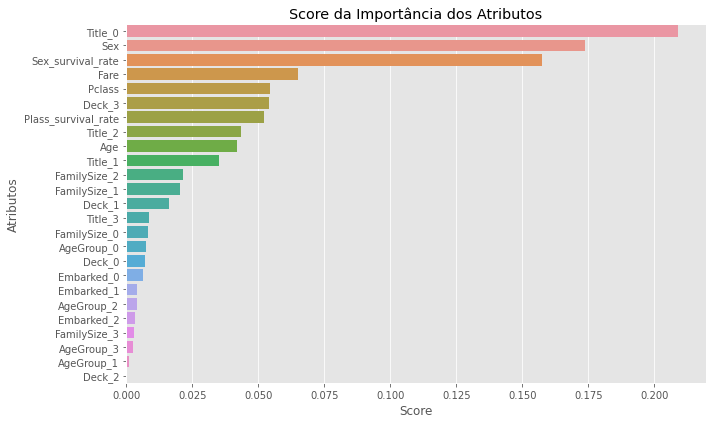

In [881]:
feature_imp = pd.Series(rdf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Score')
plt.ylabel('Atributos')
plt.title("Score da Importância dos Atributos")
plt.tight_layout()

##  Arvore de decisão

In [882]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': range(2,30,2),
              'min_samples_leaf': range(2,10,2),
              'min_impurity_decrease': np.linspace(0,0.5,10)}
dtc = DecisionTreeClassifier()
gs = GridSearchCV(dtc, param_grid=param_grid)
gs.fit(tr_x, tr_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                

### Predição e avaliação do modelo

In [883]:
# Melhores parametros apontados pelo grid search
dtc = gs.best_estimator_

dtc.fit(tr_x, tr_y)
y_pred = dtc.predict(te_x)
print(classification_report(te_y, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       165
           1       0.79      0.72      0.75       103

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.82      0.82      0.82       268



In [884]:
features_names = ['Pclass', 'Sex', 'Age', 'Fare', 'Sex_survival_rate',
       'Plass_survival_rate', 'Embarked_0', 'Embarked_1', 'Embarked_2',
       'AgeGroup_0', 'AgeGroup_1', 'AgeGroup_2', 'AgeGroup_3', 'Title_0',
       'Title_1', 'Title_2', 'Title_3', 'Deck_0', 'Deck_1', 'Deck_2', 'Deck_3',
       'FamilySize_0', 'FamilySize_1', 'FamilySize_2', 'FamilySize_3']

In [885]:
text_representation = tree.export_text(dtc, features_names)
print(text_representation)

|--- Title_0 <= 0.50
|   |--- Plass_survival_rate <= 0.35
|   |   |--- Fare <= 0.05
|   |   |   |--- Age <= 0.34
|   |   |   |   |--- class: 1
|   |   |   |--- Age >  0.34
|   |   |   |   |--- class: 0
|   |   |--- Fare >  0.05
|   |   |   |--- FamilySize_2 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- FamilySize_2 >  0.50
|   |   |   |   |--- class: 0
|   |--- Plass_survival_rate >  0.35
|   |   |--- Fare <= 0.06
|   |   |   |--- Age <= 0.61
|   |   |   |   |--- class: 1
|   |   |   |--- Age >  0.61
|   |   |   |   |--- class: 0
|   |   |--- Fare >  0.06
|   |   |   |--- Sex_survival_rate <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Sex_survival_rate >  0.50
|   |   |   |   |--- class: 1
|--- Title_0 >  0.50
|   |--- Deck_3 <= 0.50
|   |   |--- Deck_1 <= 0.50
|   |   |   |--- Fare <= 0.06
|   |   |   |   |--- class: 0
|   |   |   |--- Fare >  0.06
|   |   |   |   |--- class: 0
|   |   |--- Deck_1 >  0.50
|   |   |   |--- AgeGroup_2 <= 0.50
|   |   |   |   |--- class

[[145  20]
 [ 29  74]]


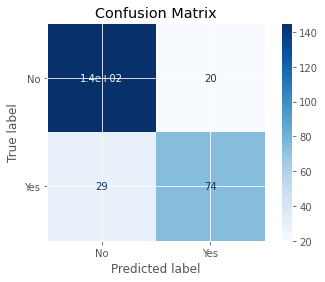

In [886]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(dtc, te_x, te_y,
                                 display_labels=["No", "Yes"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

## K-Neighbors Classifier

In [887]:
from sklearn.neighbors import KNeighborsClassifier
param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': range(1,15,2),
              'metric': ['euclidean', 'manhattan']}

knc = KNeighborsClassifier()
gs = GridSearchCV(knc, param_grid=param_grid)
gs.fit(tr_x, tr_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 15, 2),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Predição e avaliação do modelo

In [888]:
# Melhores parametros apontados pelo grid search
knc = gs.best_estimator_

knc.fit(tr_x, tr_y)
y_pred = knc.predict(te_x)
print(classification_report(te_y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       165
           1       0.76      0.65      0.70       103

    accuracy                           0.79       268
   macro avg       0.78      0.76      0.77       268
weighted avg       0.79      0.79      0.78       268



[[144  21]
 [ 36  67]]


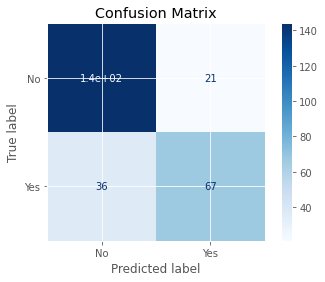

In [889]:
disp = plot_confusion_matrix(knc, te_x, te_y,
                                display_labels=["No", "Yes"],
                                cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

## SVM

In [890]:
from sklearn.svm import NuSVC
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'decision_function_shape' : ['ovo', 'ovr']}

svc = NuSVC()
gs = GridSearchCV(svc, param_grid=param_grid)
gs.fit(tr_x, tr_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=NuSVC(break_ties=False, cache_size=200,
                             class_weight=None, coef0=0.0,
                             decision_function_shape='ovr', degree=3,
                             gamma='scale', kernel='rbf', max_iter=-1, nu=0.5,
                             probability=False, random_state=None,
                             shrinking=True, tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'decision_function_shape': ['ovo', 'ovr'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Predição e avaliação do modelo

In [891]:
# Melhores parametros apontados pelo grid search
svc = gs.best_estimator_

svc.fit(tr_x, tr_y)
y_pred = svc.predict(te_x)
print(classification_report(te_y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       165
           1       0.79      0.75      0.77       103

    accuracy                           0.83       268
   macro avg       0.82      0.81      0.82       268
weighted avg       0.83      0.83      0.83       268



[[145  20]
 [ 26  77]]


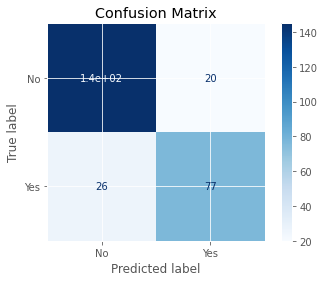

In [892]:
disp = plot_confusion_matrix(svc, te_x, te_y,
                                 display_labels=["No", "Yes"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

## Naive Bayes

In [893]:
from sklearn.naive_bayes import MultinomialNB
param_grid = {'alpha': np.linspace(0.1,2,5),
              'fit_prior': [False,True]}

mnb = MultinomialNB()
gs = GridSearchCV(mnb, param_grid=param_grid)
gs.fit(tr_x, tr_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.1  , 0.575, 1.05 , 1.525, 2.   ]),
                         'fit_prior': [False, True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Predição e avaliação do modelo

In [894]:
# Melhores parametros apontados pelo grid search
mnb = gs.best_estimator_

mnb.fit(tr_x, tr_y)
y_pred = mnb.predict(te_x)
print(classification_report(te_y, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       165
           1       0.71      0.80      0.75       103

    accuracy                           0.80       268
   macro avg       0.79      0.80      0.79       268
weighted avg       0.81      0.80      0.80       268



[[132  33]
 [ 21  82]]


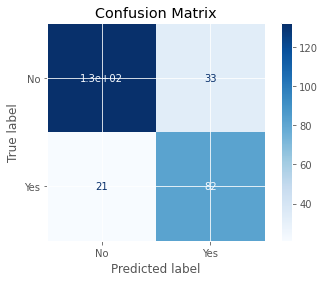

In [895]:
disp = plot_confusion_matrix(mnb, te_x, te_y,
                                 display_labels=["No", "Yes"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

## Logistic regression

In [896]:
from sklearn.linear_model import LogisticRegression
param_grid = {'penalty' : ['l2'],
              'fit_intercept': [False,True],
              'solver' : ['newton-cg', 'liblinear']}

lr = LogisticRegression()
gs = GridSearchCV(lr, param_grid=param_grid)
gs.fit(tr_x, tr_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [False, True], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Predição e avaliação do modelo

In [897]:
# Melhores parametros apontados pelo grid search
lr = gs.best_estimator_

lr.fit(tr_x, tr_y)
y_pred = lr.predict(te_x)
print(classification_report(te_y, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       165
           1       0.77      0.79      0.78       103

    accuracy                           0.83       268
   macro avg       0.82      0.82      0.82       268
weighted avg       0.83      0.83      0.83       268



[[141  24]
 [ 22  81]]


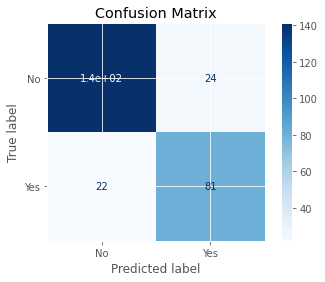

In [898]:
disp = plot_confusion_matrix(lr, te_x, te_y,
                                 display_labels=["No", "Yes"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

In [904]:
# Random Forest
predRDF =  rdf.predict(te_x)
acc_RDF = accuracy_score(te_y, predRDF)

# Decision Tree
predDTC =  dtc.predict(te_x)
acc_DTC = accuracy_score(te_y, predDTC)

# KNC
predKNC =  knc.predict(te_x)
acc_KNC = accuracy_score(te_y, predKNC)

# SVC
predSVC =  svc.predict(te_x)
acc_SVC = accuracy_score(te_y, predSVC)

# Naive Bayes
predMNB =  mnb.predict(te_x)
acc_NB = accuracy_score(te_y, predRDF)

# Logistic Regression
predLR =  lr.predict(te_x)
acc_LR = accuracy_score(te_y, predLR)

## Comparação entre modelos

In [905]:
models = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'KNC', 'SVC', 
              'Naive Bayes',  'Logistic Regression'],
    'Score': [acc_RDF, acc_DTC, acc_KNC, acc_SVC, 
              acc_NB, acc_LR]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,Decision Tree,0.828358
3,SVC,0.828358
5,Logistic Regression,0.828358
0,Random Forest,0.805970
4,Naive Bayes,0.805970
2,KNC,0.787313


## Validação Final com Gender Submission

Uma vez treinados os modelos, fez-se o teste de predição no dataset de test, original do Kaggle, e então o cálculo de acurácia ao se comparar com uma predição hipotética que considera que todas e apenas mulheres sobreviveram ao acidente. 


> **We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.**



In [899]:
# Random Forest
predRDF =  rdf.predict(x_te)
acc_RDF = accuracy_score(validation['Survived'], final_predRDF)

# Decision Tree
dtc = gs.best_estimator_
final_predDTC =  dtc.predict(X_test)
acc_DT = accuracy_score(validation['Survived'], final_predDTC)

# KNC
final_predKNC =  knc.predict(X_test)
acc_KNC = accuracy_score(validation['Survived'], final_predKNC)

# SVC
final_predSVC =  svc.predict(X_test)
acc_SVC = accuracy_score(validation['Survived'], final_predSVC)

# Naive Bayes
final_predMNB =  mnb.predict(X_test)
acc_NB = accuracy_score(validation['Survived'], final_predMNB)

# Logistic Regression
final_predLR =  lr.predict(X_test)
acc_LR = accuracy_score(validation['Survived'], final_predLR)

In [900]:
models = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'KNC', 'SVC', 
              'Naive Bayes',  'Logistic Regression'],
    'Score': [acc_RDF, acc_DT, acc_KNC, acc_SVC, 
              acc_NB, acc_LR]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Random Forest,0.966507
3,SVC,0.947368
4,Naive Bayes,0.940191
1,Decision Tree,0.925837
5,Logistic Regression,0.925837
2,KNC,0.858852


In [906]:
submission_RDF = pd.DataFrame({"PassengerId": passengerId, "Survived": final_predRDF })
submission_DTC = pd.DataFrame({"PassengerId": passengerId, "Survived": final_predDTC })
submission_KNC = pd.DataFrame({"PassengerId": passengerId, "Survived": final_predKNC })
submission_SVC = pd.DataFrame({"PassengerId": passengerId, "Survived": final_predSVC })
submission_MNB = pd.DataFrame({"PassengerId": passengerId, "Survived": final_predMNB })
submission_LR = pd.DataFrame({"PassengerId": passengerId, "Survived": final_predLR })

submission_RDF.to_csv('/content/submission_RDF.csv', index = False)
submission_DTC.to_csv('/content/submission_DTC.csv', index = False)
submission_KNC.to_csv('/content/submission_KNC.csv', index = False)
submission_SVC.to_csv('/content/submission_SVC.csv', index = False)
submission_MNB.to_csv('/content/submission_MNB.csv', index = False)
submission_LR.to_csv('/content/submission_LR.csv', index = False)

## Teste no Kaggle

Foi submetida a predição por Random Forest no Kaggle e o resultado foi de 0,77990. 

![](https://i.imgur.com/rVQKWzL.png)

# Referências

1. kaggle.com. (n.d.). Titanic - Advanced Feature Engineering Tutorial. [online] Available at: https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial#3.-Model [Accessed 19 Dec. 2020].

2. Wikipedia Contributors (2019). English honorifics. [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/English_honorifics.

3. triangleinequality (2013). Basic Feature Engineering with the Titanic Data. [online] triangleinequality. Available at: https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/ [Accessed 20 Dec. 2020]
4. Scikit-learn.org. (2019). scikit-learn: machine learning in Python — scikit-learn 0.20.3 documentation. [online] Available at: https://scikit-learn.org/stable/index.html.
5. Spark, C. (2019). Tutorial: Introduction to Missing Data Imputation. [online] Medium. Available at: https://medium.com/@Cambridge_Spark/tutorial-introduction-to-missing-data-imputation-4912b51c34eb.

6. kaggle.com. (n.d.). Titanic: Machine Learning from Disaster. [online] Available at: https://www.kaggle.com/c/titanic.
‌
